# Seismic Transformer V3.0 train book

*Author: Jason Jiang (Xunfun Lee)*

*Date: 2023.01.13*

> **Note:** This is a cookbook for Seismic Transformer V3.0 training. For the reason is data format become HDF5 (all the data is process completely) and process is different from previous version. So I write the notebook before writing python scripts for modularization.

## Ready

In [1]:
from PythonScripts.utility import SetDevice

device = SetDevice()

GPU: cuda
CUDA device numbers:  1


## Load the data

All the data is stored in HDF5 format. The data is stored in the following format:

Ground motion data - input of the encoder (after PGAs expand)
- `Acc_GMs_train.h5`: (100622, 3000)
- `Acc_GMs_validation.h5`: (97356, 3000)
- `Acc_GMs_test.h5`: (3705, 3000)

Damage state - input of the encoder
- `DS_Blg_train.h5`: (57, 1766, 1)
- `DS_Blg_validation.h5`: (57, 1708, 1)
- `DS_Blg_test.h5`: (57, 65, 1)

Floor response data - input of the decoder
- `Acc_Blg_train.h5`: (57, 1766, 3000)
- `Acc_Blg_validation.h5`: (57, 1708, 3000)
- `Acc_Blg_test.h5`: (57, 65, 3000)

Notices:
1. 57 is the number of PGAs, from 0.1 to 20, 57 in total.
2. 1766, 1708, 65 is the number of ground motions.

### Read `hdf5` file function

You can merge all h5 file to a single h5 file with different "dataset_name".

In [2]:
import h5py
import numpy as np
import os

def ReadH5File(path:str,
               dataset_name:str) -> np.ndarray:
    
    # Check if the file exists
    if not os.path.exists(path):
        raise FileNotFoundError(f"The file at {path} does not exist.")

    with h5py.File(path, 'r') as f:
        # Check if the dataset exists
        if dataset_name not in f:
            raise KeyError(f"Dataset {dataset_name} not found in the file.")

        data_read = f[dataset_name][:]

        # Check if the dataset is empty
        if data_read.size == 0:
            raise ValueError(f"The dataset {dataset_name} is empty.")

        print("Data read successfully")

    return data_read

file_path = 'I:\Graduation\Data_MDOF\Data_h5'

### Ground motion data

In [3]:
Acc_GM_Train_Path = "Acc_GMs_train.h5"
Acc_GM_Validation_Path = "Acc_GMs_validation.h5"
Acc_GM_Test_Path = "Acc_GMs_test.h5"

dataset_name_acc_gm = 'Acc_GMs'

Acc_GM_Train = ReadH5File(path=os.path.join(file_path, Acc_GM_Train_Path), dataset_name=dataset_name_acc_gm)
Acc_GM_Validation = ReadH5File(path=os.path.join(file_path, Acc_GM_Validation_Path), dataset_name=dataset_name_acc_gm)
Acc_GM_Test = ReadH5File(path=os.path.join(file_path, Acc_GM_Test_Path), dataset_name=dataset_name_acc_gm)

Acc_GM_Train.shape, Acc_GM_Validation.shape, Acc_GM_Test.shape

Data read successfully
Data read successfully
Data read successfully


((100662, 3000), (97356, 3000), (3705, 3000))

### Damage state

In [4]:
DS_Train_Path = "DS_Blg_train.h5"
DS_Validation_Path = "DS_Blg_validation.h5"
DS_Test_Path = "DS_Blg_test.h5"

dataset_name_ds = 'damage_state'       # dataset_name is important in h5 file

DS_GM_Train = ReadH5File(path=os.path.join(file_path, DS_Train_Path), dataset_name=dataset_name_ds)
DS_GM_Validation = ReadH5File(path=os.path.join(file_path, DS_Validation_Path), dataset_name=dataset_name_ds)
DS_GM_Test = ReadH5File(path=os.path.join(file_path, DS_Test_Path), dataset_name=dataset_name_ds)

DS_GM_Train.shape, DS_GM_Validation.shape, DS_GM_Test.shape

Data read successfully
Data read successfully
Data read successfully


((57, 1766, 1), (57, 1708, 1), (57, 65, 1))

### Floor response data

In [5]:
Acc_Blg_Train_Path = "Acc_Blg_train.h5"
Acc_Blg_Validation_Path = "Acc_Blg_validation.h5"
Acc_Blg_Test_Path = "Acc_Blg_test.h5"

dataset_name_acc_blg = 'dataset_name'       # forget to set the name of dataset :(

Acc_Blg_Train = ReadH5File(path=os.path.join(file_path, Acc_Blg_Train_Path), dataset_name=dataset_name_acc_blg)
Acc_Blg_Validation = ReadH5File(path=os.path.join(file_path, Acc_Blg_Validation_Path), dataset_name=dataset_name_acc_blg)
Acc_Blg_Test = ReadH5File(path=os.path.join(file_path, Acc_Blg_Test_Path), dataset_name=dataset_name_acc_blg)

Acc_Blg_Train.shape, Acc_Blg_Validation.shape, Acc_Blg_Test.shape

Data read successfully
Data read successfully
Data read successfully


((57, 1766, 3000), (57, 1708, 3000), (57, 65, 3000))

### Reshape array

Damage state and floor response data need to be reshape.

`reshape()` won't change the order of the array, just change the view of the array.

In [6]:
# DS_GM_Train=DS_GM_Train.reshape(-1, 1)
# DS_GM_Validation=DS_GM_Validation.reshape(-1, 1)
# DS_GM_Test=DS_GM_Test.reshape(-1, 1)

DS_Blg_Train_tp = np.transpose(DS_GM_Train, (1, 0, 2))
DS_Blg_Validation_tp = np.transpose(DS_GM_Validation, (1, 0, 2))
DS_Blg_Test_tp = np.transpose(DS_GM_Test, (1, 0, 2))

DS_Blg_Train_merge = DS_Blg_Train_tp.reshape(100662,1)
DS_Blg_Validation_merge = DS_Blg_Validation_tp.reshape(97356,1)
DS_Blg_Test_merge = DS_Blg_Test_tp.reshape(3705,1)

# Acc_Blg_Train=Acc_Blg_Train.reshape(-1, 1)
# Acc_Blg_Validation=Acc_Blg_Validation.reshape(-1, 1)
# Acc_Blg_Test=Acc_Blg_Test.reshape(-1, 1)

# Acc_Blg_Train_tp = np.transpose(Acc_Blg_Train, (1, 0, 2))
# Acc_Blg_Validation_tp = np.transpose(Acc_Blg_Validation, (1, 0, 2))
# Acc_Blg_Test_tp = np.transpose(Acc_Blg_Test, (1, 0, 2))

Acc_Blg_Train_tp = Acc_Blg_Train.transpose(1, 0, 2)
Acc_Blg_Validation_tp = Acc_Blg_Validation.transpose(1, 0, 2)
Acc_Blg_Test_tp = Acc_Blg_Test.transpose(1, 0, 2)

Acc_Blg_Test_tp.shape, Acc_Blg_Train_tp.shape, Acc_Blg_Validation_tp.shape

((65, 57, 3000), (1766, 57, 3000), (1708, 57, 3000))

In [7]:
Acc_Blg_Train_merge = Acc_Blg_Train_tp.reshape(100662,3000)
Acc_Blg_Validation_merge = Acc_Blg_Validation_tp.reshape(97356,3000)
Acc_Blg_Test_merge = Acc_Blg_Test_tp.reshape(3705,3000)

Acc_Blg_Train_merge.shape, Acc_Blg_Validation_merge.shape, Acc_Blg_Test_merge.shape

((100662, 3000), (97356, 3000), (3705, 3000))

In [8]:
Acc_GM_Train.shape, Acc_GM_Validation.shape, Acc_GM_Test.shape

((100662, 3000), (97356, 3000), (3705, 3000))

In [9]:
DS_Blg_Train_merge.shape, DS_Blg_Validation_merge.shape, DS_Blg_Test_merge.shape

((100662, 1), (97356, 1), (3705, 1))

In [10]:
Acc_Blg_Train.shape, Acc_Blg_Validation.shape, Acc_Blg_Test.shape

((57, 1766, 3000), (57, 1708, 3000), (57, 65, 3000))

PS: SeT-3 need input of (100662, 3000, 1), we add an extra dimension inside the dataset class.

## Check 

Check if the data load in to data loader is correct before loding

In [11]:
import matplotlib.pyplot as plt

def PlotA(times:np.ndarray, acc:np.ndarray, index:int, save:bool=False):
    plt.figure(figsize=(10, 2.5))
    plt.plot(times, acc[index], marker='o', linestyle='-')
    plt.xlabel('Time (s)')
    plt.ylabel('Acceleration (m/s^2)')
    plt.grid(True)
    plt.legend(['Acceleration'])
    plt.show()

def PlotB(times:np.ndarray, acc:np.ndarray, index_blg:int, index_gm:int, save:bool=False):
    plt.figure(figsize=(10, 2.5))
    plt.plot(times, acc[index_blg][index_gm], marker='o', linestyle='-')
    plt.xlabel('Time (s)')
    plt.ylabel('Acceleration (m/s^2)')
    plt.grid(True)
    plt.legend(['Acceleration'])
    plt.show()

indices of data: 1522


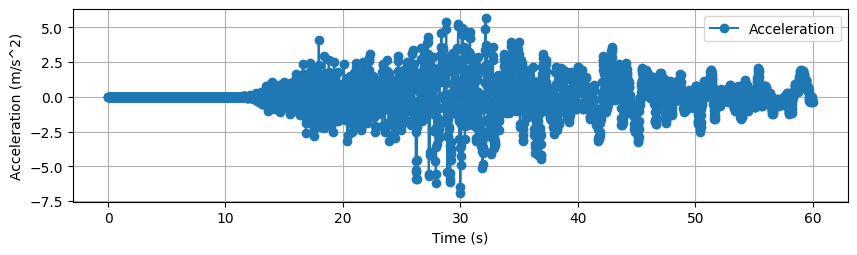

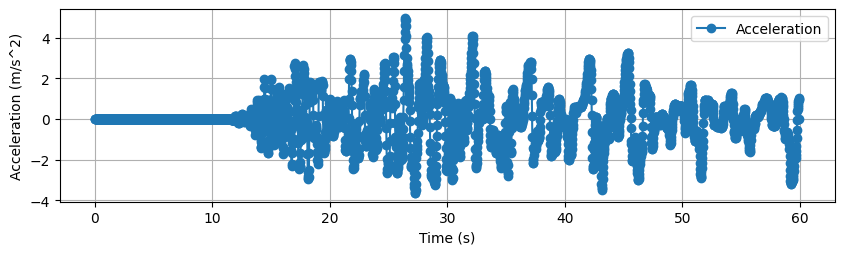

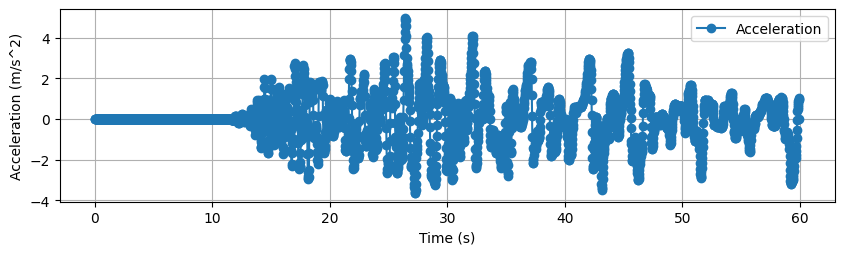

In [12]:
import random
index_data = random.randint(0, len(Acc_GM_Test))
index_gm = index_data // 57
index_blg = index_data % 57

times = np.linspace(0, 59.98, 3000)
print(f"indices of data: {index_data}")

# train data
# PlotA(times=times, acc=Acc_GM_Train, index=index_data, save=False)                          # original grounmotion data
# PlotA(times=times, acc=Acc_Blg_Train_merge, index=index_data, save=False)                   # Check if the data after transformed is correct (blg)
# PlotB(times=times, acc=Acc_Blg_Train, index_gm=index_gm, index_blg=index_blg,save=False)    # the original data before transformed (blg)

# validation data
PlotA(times=times, acc=Acc_GM_Validation, index=index_data, save=False)
PlotA(times=times, acc=Acc_Blg_Validation_merge, index=index_data, save=False)
PlotB(times=times, acc=Acc_Blg_Validation, index_gm=index_gm, index_blg=index_blg,save=False)

# test data         have big problem!!!
# PlotA(times=times, acc=Acc_GM_Test, index=index_data, save=False)                          # original grounmotion data
# PlotA(times=times, acc=Acc_Blg_Test_merge, index=index_data, save=False)                   # Check if the data after transformed is correct (blg)
# PlotB(times=times, acc=Acc_Blg_Test, index_gm=index_gm, index_blg=index_blg,save=False)    # the original data before transformed (blg)

## Mask generate

### Key padding mask

Well, I think this is not the most important parts of the SeismicTransformer. But in coding, it is more reasnoble to use it, for more clean code. It has been used in SeT-2, so we have the code already.

For test purposed here, we use a all true mask (so there is no mask at all).

Moreover, in classification task, we can using padding mask, but when we are using regression task, we can't use padding mask. So i think it is not necessary to use padding mask in SeT-3. However, since the code is already written, we just using all False mask which stands for no mask at all in SeT-3 model.

In [13]:
import torch

def create_key_padding_mask(size):
    mask = torch.zeros(size)
    return mask == 1  # convert to bool

key_padding_mask = create_key_padding_mask(14)

key_padding_mask, key_padding_mask.shape

(tensor([False, False, False, False, False, False, False, False, False, False,
         False, False, False, False]),
 torch.Size([14]))

### Look ahead mask

Look ahead mask is used in the decoder, to prevent the decoder to see the future information.

In fact, for our Seq2Seq task, we can use the exact one look ahead mask because our sequence length is fixed.

For Multi-head attention input, just need to pass in a up triangle matrix by using `torch.triu()`.

In [14]:
def create_look_ahead_mask(size):
    mask = torch.triu(torch.ones(size, size), diagonal=1)
    return mask == 1  # convert to bool

max_seq_len = 12  # length of the sequence
look_ahead_mask = create_look_ahead_mask(max_seq_len)

look_ahead_mask

tensor([[False,  True,  True,  True,  True,  True,  True,  True,  True,  True,
          True,  True],
        [False, False,  True,  True,  True,  True,  True,  True,  True,  True,
          True,  True],
        [False, False, False,  True,  True,  True,  True,  True,  True,  True,
          True,  True],
        [False, False, False, False,  True,  True,  True,  True,  True,  True,
          True,  True],
        [False, False, False, False, False,  True,  True,  True,  True,  True,
          True,  True],
        [False, False, False, False, False, False,  True,  True,  True,  True,
          True,  True],
        [False, False, False, False, False, False, False,  True,  True,  True,
          True,  True],
        [False, False, False, False, False, False, False, False,  True,  True,
          True,  True],
        [False, False, False, False, False, False, False, False, False,  True,
          True,  True],
        [False, False, False, False, False, False, False, False, False, F

## Create dataloader

In [15]:
from torch.utils.data import Dataset, DataLoader

# 自定义数据集类
class AccBlg_AccGM_DS_V3(Dataset):
    def __init__(self, acc_gm, acc_blg, ds_gm):
        # 假设 acc_gm, acc_blg, ds_gm 是已加载的数据
        self.acc_gm = acc_gm
        self.acc_blg = acc_blg
        self.ds_gm = ds_gm

    def __len__(self):
        return len(self.ds_gm)

    def __getitem__(self, idx):
        # 获取索引为 idx 的数据
        acc_gm_sample = self.acc_gm[idx]
        acc_blg_sample = self.acc_blg[idx]
        ds_gm_sample = self.ds_gm[idx]

        # 转换为 PyTorch Tensor
        acc_gm_sample = torch.tensor(acc_gm_sample, dtype=torch.float32)
        acc_blg_sample = torch.tensor(acc_blg_sample, dtype=torch.float32)
        ds_gm_sample = torch.tensor(ds_gm_sample, dtype=torch.float32)

        # (100662, 3000) --> (100662, 3000, 1)
        acc_gm_sample = acc_gm_sample.unsqueeze(-1)
        acc_blg_sample = acc_blg_sample.unsqueeze(-1)

        # (100662, 1) --> (100662)
        ds_gm_sample = ds_gm_sample.squeeze(-1)

        return acc_gm_sample, acc_blg_sample, ds_gm_sample


In [16]:
# 创建数据集实例
train_dataset = AccBlg_AccGM_DS_V3(Acc_GM_Train, Acc_Blg_Train_merge, DS_Blg_Train_merge)
validation_dataset = AccBlg_AccGM_DS_V3(Acc_GM_Validation, Acc_Blg_Validation_merge, DS_Blg_Validation_merge)
test_dataset = AccBlg_AccGM_DS_V3(Acc_GM_Test, Acc_Blg_Test_merge, DS_Blg_Test_merge)

In [17]:
# 创建 DataLoader
BATCH_SIZE = 256

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
validation_dataloader = DataLoader(validation_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

train_dataloader, validation_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x2acd39336a0>,
 <torch.utils.data.dataloader.DataLoader at 0x2ac9f8c41f0>)

### Visualize the data

In [18]:
acc_gm, acc_blg, damage_state = next(iter(train_dataloader))

acc_gm.shape, acc_blg.shape, damage_state.shape

(torch.Size([256, 3000, 1]), torch.Size([256, 3000, 1]), torch.Size([256]))

In [19]:
import matplotlib.pyplot as plt
import numpy as np
# Generate 3000 points for 60s
times = np.linspace(0, 59.98, 3000)

def Plot(times:np.ndarray, acc:np.ndarray, damage_state:np.ndarray, index:int, save:bool=False):
    plt.figure(figsize=(15, 5))
    plt.plot(times, acc[index], marker='o', linestyle='-')
    plt.title(damage_state[index])
    plt.xlabel('Time (s)')
    plt.ylabel('Acceleration (m/s^2)')
    plt.grid(True)
    plt.legend(['Acceleration'])
    plt.show()

    if save == True:
        filename = 'example_data.txt'
        with open(filename, 'w') as file:
            file.write('3000\n')  # 写入标题
            for x, y in zip(times, acc[index]):
                file.write(f'{x:.2f}\t{y.item()}\n')  # 写入每行的数据


Index: 77


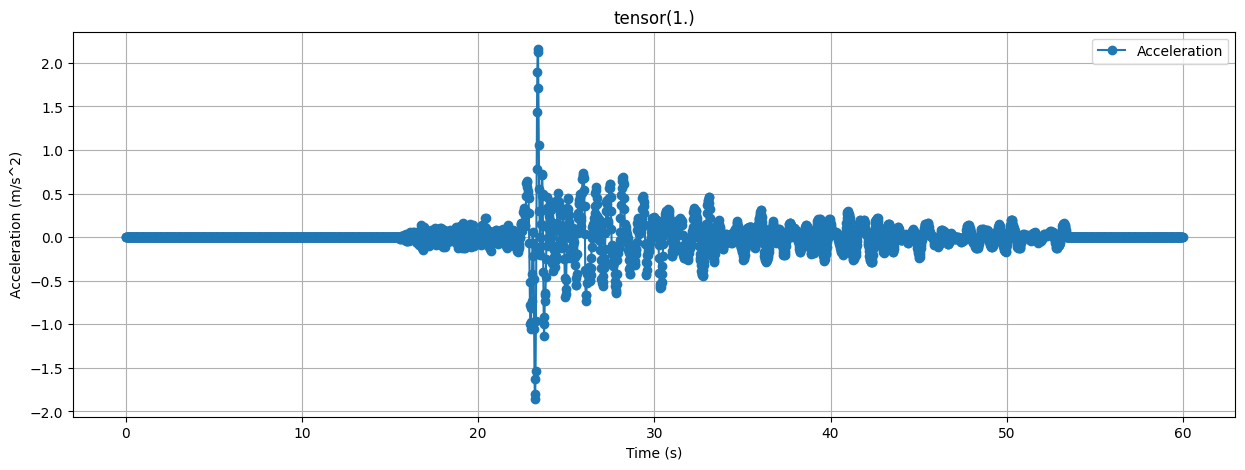

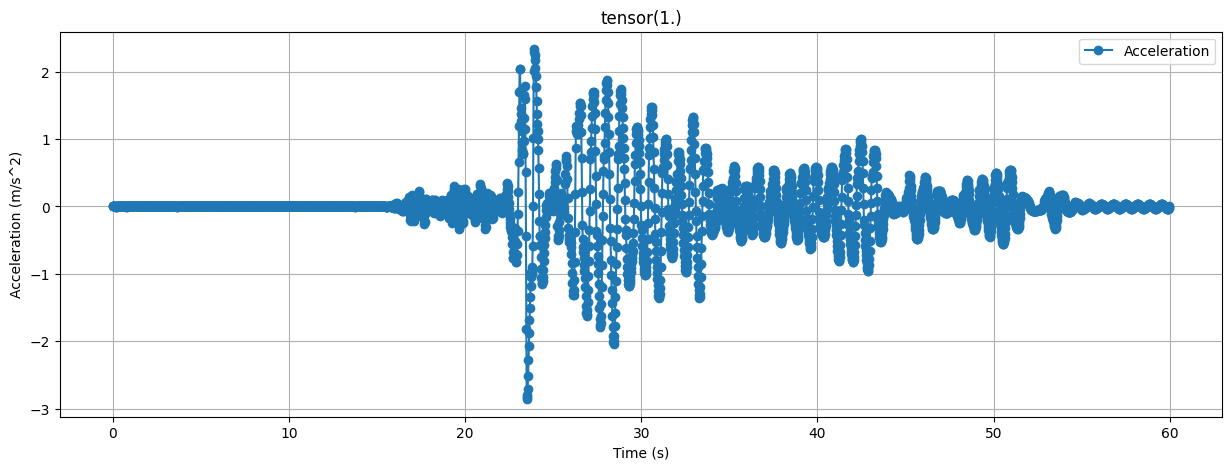

In [20]:
import random
index = random.randint(0, BATCH_SIZE-1)
print(f"Index: {index}")

Plot(times, acc_gm, damage_state, index, True)          # Ground motion
Plot(times, acc_blg, damage_state, index, False)        # Building acceleration by MDOF

## Build the SeT-3 model

Since we have built the SeT-3 in `SeT_3_CookBook.ipynb`, here we just need to write the code to python scripts based on that and import here.

In [21]:
from PythonScripts.transformer import SeismicTransformerV3

SeismicTransformerV3_instance = SeismicTransformerV3().to(device)

### * Put seq into the model directly before training

Since we have a problem in inference mode, just test it before.

In [22]:
acc_gm, acc_blg, damage_state = next(iter(validation_dataloader))

acc_gm.shape, acc_blg.shape, damage_state.shape

(torch.Size([256, 3000, 1]), torch.Size([256, 3000, 1]), torch.Size([256]))

Index: 244


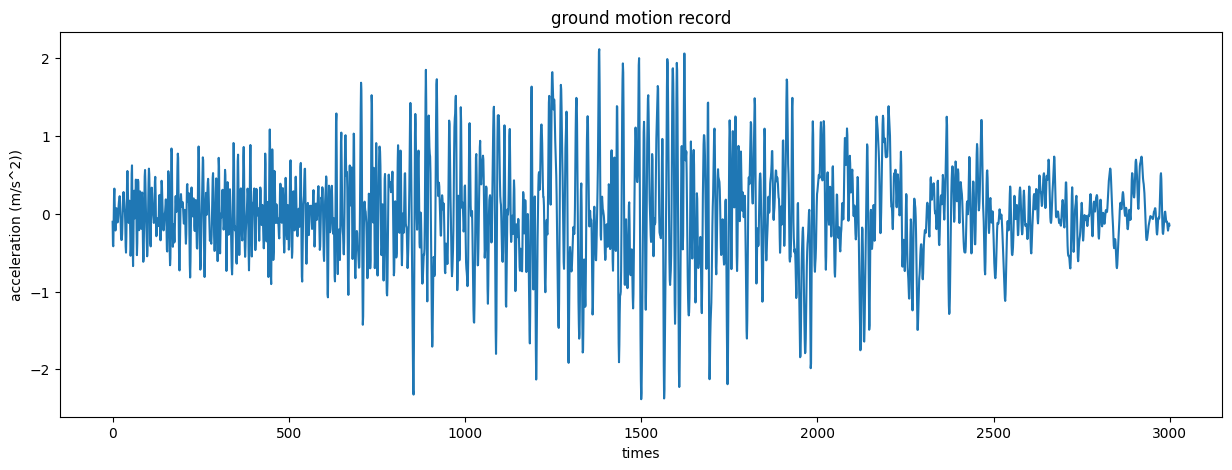

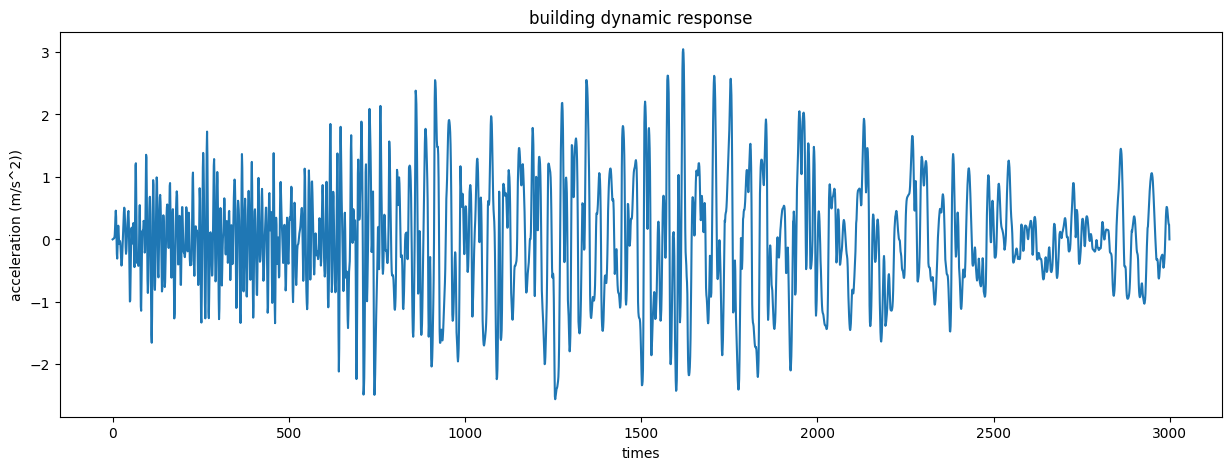

In [23]:
import random
index_test = random.randint(0, BATCH_SIZE)
print(f"Index: {index_test}")

# 绘制曲线图
plt.figure(figsize=(15, 5))
plt.plot(acc_gm[index_test])
plt.xlabel('times')
plt.ylabel('acceleration (m/s^2))')
plt.title('ground motion record')
plt.show()

# 绘制曲线图
plt.figure(figsize=(15, 5))
plt.plot(acc_blg[index_test])
plt.xlabel('times')
plt.ylabel('acceleration (m/s^2))')
plt.title('building dynamic response')
plt.show()

In [24]:
# 创建一个大小为 (1, 3000, 1) 的全0张量
zero_tensor = torch.zeros((1, 3000, 1)).to(device)
zero_tensor.shape, zero_tensor

(torch.Size([1, 3000, 1]),
 tensor([[[0.],
          [0.],
          [0.],
          ...,
          [0.],
          [0.],
          [0.]]], device='cuda:0'))

In [25]:
import torch
import numpy as np

# 将numpy数组转换为torch张量
input_encoder = torch.tensor(acc_gm[index_test], dtype=torch.float32).to(device)
input_decoder = torch.tensor(acc_blg[index_test], dtype=torch.float32).to(device)

input_encoder = input_encoder.unsqueeze(0)
input_decoder = input_decoder.unsqueeze(0)

input_encoder.shape, input_decoder.shape

C:\Users\Administrator\AppData\Local\Temp\ipykernel_22336\1147786418.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input_encoder = torch.tensor(acc_gm[index_test], dtype=torch.float32).to(device)
C:\Users\Administrator\AppData\Local\Temp\ipykernel_22336\1147786418.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input_decoder = torch.tensor(acc_blg[index_test], dtype=torch.float32).to(device)


(torch.Size([1, 3000, 1]), torch.Size([1, 3000, 1]))

In [26]:
SeismicTransformerV3_instance.eval()  # 将模型设置为评估模式

with torch.no_grad():  # 在推理过程中，我们不需要计算梯度
    
    # 注意，由于我们只进行推理，decoder_input参数设置为None
    damage_state, dynamic_response = SeismicTransformerV3_instance(encoder_input=input_encoder, decoder_input=None)

    # 输出结果
    damage_state, dynamic_response, damage_state.shape, dynamic_response.shape

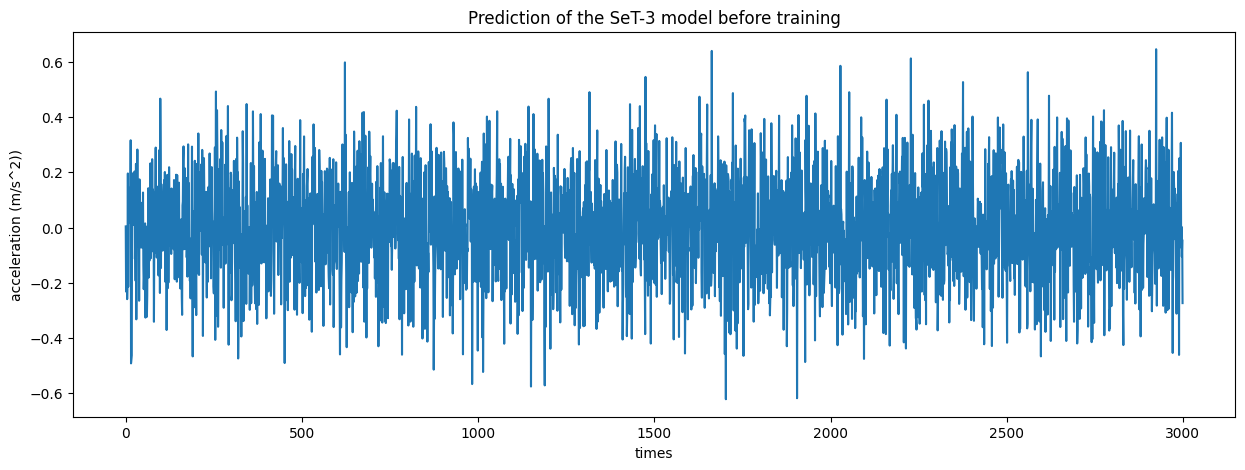

In [27]:
import matplotlib.pyplot as plt
import torch

# 将tensor转换为numpy数组，并移除多余的维度
numpy_array = dynamic_response.squeeze().cpu().detach().numpy()

# 绘制曲线图
plt.figure(figsize=(15, 5))
plt.plot(numpy_array)
plt.xlabel('times')
plt.ylabel('acceleration (m/s^2))')
plt.title('Prediction of the SeT-3 model before training')
plt.show()

## Train the model

Since we have built the train function in `SeT_3_CookBook.ipynb`, here we just need to write the code to python scripts based on that and import here.

### Loss function and optimizer


In [28]:
from torch.nn import CrossEntropyLoss, MSELoss
from transformers import get_linear_schedule_with_warmup

loss_fn_classification = CrossEntropyLoss()
loss_fn_regression = MSELoss()

# tring adamW in SeT-3
optimizer = torch.optim.AdamW(SeismicTransformerV3_instance.parameters(), lr=1e-3, weight_decay=0.0)
# optimizer = torch.optim.Adam(params=SeismicTransformerV3_instance.parameters(), 
#                              lr=0.001,
#                              betas=(0.9, 0.999),
#                              weight_decay=0.0)

NUM_EPOCH = 30

num_training_steps = (Acc_Blg_Train_merge.shape[0] / BATCH_SIZE) * NUM_EPOCH         # total steps = len(train_dataset) / batch_size * epochs
num_warmup_steps = num_training_steps * 0.2  # warmup_ratio usually is 20% of the total steps

lr_scheduler_warmup = get_linear_schedule_with_warmup(optimizer,
                                                      num_warmup_steps=num_warmup_steps,
                                                      num_training_steps=num_training_steps)

# Set up the learning rate scheduler for decay, work inside train()
lr_scheduler_decay = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 
                                                                mode='max', # set the min or max lr
                                                                patience=10, # how many epoch loss don't change
                                                                factor=0.1, # new_lr = old_lr * factor
                                                                threshold=0.1, # loss change
                                                                threshold_mode='rel', # compare mode
                                                                cooldown=10, # how many epoch to wait
                                                                min_lr=1e-7, # minimun of lr
                                                                verbose=True)     # print something if useful

### `Train()`

In [29]:
from PythonScripts.utility import CreateOutputFolder, CreateLogFileV3, CountNumOfTraining

CLASSIFICATION_WEIGHT = 0.2
HIDDEN_SIZE = 768
NUM_HEADS = 24
NUM_LAYERS = 24

In [30]:
# Count the number of csv file "training_results.csv"
num_of_training = CountNumOfTraining()

# Create output folder
save_dir = CreateOutputFolder(num_of_training=num_of_training+1,
                              hidden_size=HIDDEN_SIZE,
                              num_of_layer=NUM_LAYERS,
                              num_of_head=NUM_HEADS,
                              num_of_epoch=NUM_EPOCH)

# Create log file, a csv file                  
log_filename = CreateLogFileV3(save_dir=save_dir)

In [31]:
from PythonScripts.train import train_set3
import time

# Caculate the start time of the training
strat_time = time.time()

results = train_set3(model=SeismicTransformerV3_instance,
                    train_loader=train_dataloader,
                    val_loader=validation_dataloader,
                    loss_fn_classification=loss_fn_classification,
                    loss_fn_regression=loss_fn_regression,
                    loss_fn_weight_classification=CLASSIFICATION_WEIGHT,
                    optimizer=optimizer,
                    lr_scheduler_warmup=lr_scheduler_warmup,
                    lr_scheduler_decay=lr_scheduler_decay,
                    num_warmup_steps=num_warmup_steps,
                    num_epochs=NUM_EPOCH,
                    device=device,
                    log_filename=log_filename)

end_time = time.time()
total_time = end_time - strat_time
print(f"Training time: {total_time:.3f}秒")

  0%|          | 0/30 [00:00<?, ?it/s]

Epoch 000 : teacher forcing ratio = 1.0
Epoch: 1 | train_loss: 0.4434 | train_acc: 0.6271 | train_mse: 0.3500 | validation_loss: 0.9521 | validation_acc: 0.7566 | validation_mse: 1.0271
Epoch 001 : teacher forcing ratio = 0.9666666666666667
Epoch: 2 | train_loss: 0.1703 | train_acc: 0.8295 | train_mse: 0.1161 | validation_loss: 0.8802 | validation_acc: 0.7918 | validation_mse: 0.9699
Epoch 002 : teacher forcing ratio = 0.9333333333333333
Epoch: 3 | train_loss: 0.1353 | train_acc: 0.8459 | train_mse: 0.0808 | validation_loss: 0.8285 | validation_acc: 0.7923 | validation_mse: 0.8940
Epoch 003 : teacher forcing ratio = 0.9
Epoch: 4 | train_loss: 0.1225 | train_acc: 0.8586 | train_mse: 0.0724 | validation_loss: 0.7683 | validation_acc: 0.7897 | validation_mse: 0.8196
Epoch 004 : teacher forcing ratio = 0.8666666666666667
Epoch: 5 | train_loss: 0.1210 | train_acc: 0.8577 | train_mse: 0.0700 | validation_loss: 0.7430 | validation_acc: 0.7914 | validation_mse: 0.7990
Epoch 005 : teacher forci

## Test the model after training

In [32]:
SeismicTransformerV3_instance.eval()  # 将模型设置为评估模式

with torch.no_grad():  # 在推理过程中，我们不需要计算梯度
    
    # 注意，由于我们只进行推理，decoder_input参数设置为None
    damage_state, dynamic_response = SeismicTransformerV3_instance(encoder_input=input_encoder, decoder_input=None)

    # 输出结果
    damage_state, dynamic_response, damage_state.shape, dynamic_response.shape

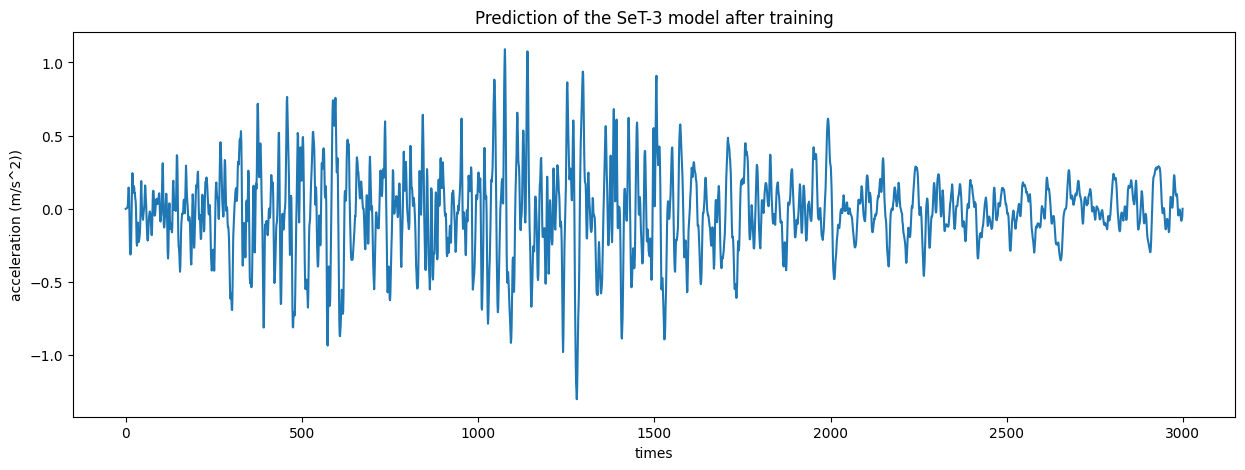

In [33]:
import matplotlib.pyplot as plt

# 将tensor转换为numpy数组，并移除多余的维度
numpy_array = dynamic_response.squeeze().cpu().detach().numpy()

# 绘制曲线图
plt.figure(figsize=(15, 5))
plt.plot(numpy_array)
plt.xlabel('times')
plt.ylabel('acceleration (m/s^2))')
plt.title('Prediction of the SeT-3 model after training')
plt.show()

## Save the model

In [34]:
from PythonScripts.utility import SaveModel

SaveModel(model=SeismicTransformerV3_instance,
          num_of_training=num_of_training,
          hidden_size=HIDDEN_SIZE,
          num_of_layer=NUM_LAYERS,
          num_of_head=NUM_HEADS,
          num_of_epoch=NUM_EPOCH,
          validation_acc=results['validation_acc'],
          f1_score=10,
          save_mode="model")

Model saved to Models\SeT_1_HS_768_Layer_24_Head_24_Epoch_30_Acc_0.78_F1_10.0_Model.pth


#### For more test please see `SeT_3_Test.ipynb`

##